In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from collections import Counter

import xgboost as xgb
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
from scipy.special import expit

/Users/xulian/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
directory = 'WDataFiles_Stage2'
os.listdir(directory)

['538ratingsWomen.csv',
 'WTeams.csv',
 'WNCAATourneySlots2022.csv',
 'WSampleSubmissionStage2.csv',
 'WNCAATourneyDetailedResults.csv',
 'WNCAATourneyCompactResults.csv',
 'WSeasons.csv',
 'Cities.csv',
 'WRegularSeasonCompactResults.csv',
 'WTeamSpellings.csv',
 'WRegularSeasonDetailedResults.csv',
 'WNCAATourneySeeds.csv',
 'WTeamConferences.csv',
 'WNCAATourneySlots1998thru2021.csv',
 'Conferences.csv',
 'WGameCities.csv']

## Data Prep

In [5]:
seasons = [2016, 2017, 2018, 2019, 2021, 2022]

### Seeds

In [6]:
df_seeds = pd.read_csv(f'{directory}/WNCAATourneySeeds.csv')
df_seeds = df_seeds[df_seeds['Season'].isin(seasons)]
df_seeds.shape

(388, 3)

In [7]:
# Check
df_seeds.groupby('Season')['TeamID'].count()

Season
2016    64
2017    64
2018    64
2019    64
2021    64
2022    68
Name: TeamID, dtype: int64

### 538

Load 538 dataset: https://www.kaggle.com/datasets/raddar/ncaa-women-538-team-ratings

In [8]:
df_538 = pd.read_csv(f'{directory}/538ratingsWomen.csv')
set(df_538.Season)

{2016, 2017, 2018, 2019, 2021, 2022}

### Season Results

In [9]:
df_season_res = pd.read_csv(f'{directory}/WRegularSeasonDetailedResults.csv')
df_season_res = df_season_res[df_season_res['Season'].isin(seasons)]

Duplicate records by switching

In [10]:
def prepare_data(df):
    df['LLoc'] = df['WLoc'].map({'N': 'N', 'H': 'A', 'A': 'H'})
    
    w_df = df.copy()
    l_df = df.copy()
    
    w_df = w_df.rename(columns={col: f'A{col[1:]}'
                                for col in w_df.columns
                                if col.startswith('W')})\
               .rename(columns={col: f'B{col[1:]}'
                                for col in w_df.columns
                                if col.startswith('L')})
    l_df = l_df.rename(columns={col: f'B{col[1:]}'
                                for col in l_df.columns
                                if col.startswith('W')})\
               .rename(columns={col: f'A{col[1:]}'
                                for col in l_df.columns
                                if col.startswith('L')})
    
    return pd.concat([w_df, l_df]).reset_index().drop('index', axis=1)

In [11]:
print('Before data prep:', df_season_res.shape)
df_season_res = prepare_data(df_season_res)
print('After data prep:', df_season_res.shape)
df_season_res.head()

Before data prep: (29484, 34)
After data prep: (58968, 35)


,Season,DayNum,ATeamID,AScore,BTeamID,BScore,ALoc,NumOT,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAst,ATO,AStl,ABlk,APF,BFGM,BFGA,BFGM3,BFGA3,BFTM,BFTA,BOR,BDR,BAst,BTO,BStl,BBlk,BPF,BLoc
0,2016,11,3104,96,3105,44,H,0,34,78,6,30,22,34,20,32,12,14,12,14,21,16,59,0,8,12,20,13,29,6,28,5,0,27,A
1,2016,11,3116,97,3368,53,H,0,37,88,7,22,16,25,28,31,23,15,14,0,21,19,56,8,24,7,12,5,29,10,27,4,2,27,A
2,2016,11,3119,63,3337,53,H,0,23,57,6,16,11,20,13,31,11,17,9,3,13,20,60,4,15,9,10,9,25,7,18,9,0,24,A
3,2016,11,3120,85,3412,71,H,0,34,64,10,30,7,12,11,21,21,9,9,3,18,26,55,12,28,7,14,10,21,16,17,6,1,17,A
4,2016,11,3124,62,3426,20,H,0,22,61,3,12,15,28,21,28,19,14,18,6,13,8,40,1,11,3,10,7,23,4,30,4,2,21,A


Use Kenpom's coefficient (https://kenpom.com/blog/the-possession/) on free throw to estimate numbers of possessions of games.  
To avoid scenarios that losing teams have a better points per possession than winning teams, average the numbers from both sides.

In [12]:
def compute_possession(df):
    # Use kenpom's calculation
    for side in ['A', 'B']:
        df[f'{side}Poss'] = df[f'{side}FGA'] - df[f'{side}OR'] + \
                            df[f'{side}TO'] + 0.44 * df[f'{side}FTA']
    df['Poss'] = (df['APoss'] + df['BPoss']) / 2
    return df

Compute Dean Oliver's four factors. For free throw rate, FTM/FGA is adopted over FTA/FGA.

In [13]:
def compute_four_factors(df):
    flip = {'A': 'B', 'B': 'A'}
    for side in ['A', 'B']:
        df[f'{side}_off_PP100P'] = df[f'{side}Score'] / df['Poss'] * 100
        df[f'{side}_off_eFG'] = (df[f'{side}FGM'] + 
                                 0.5 * df[f'{side}FGM3']) / \
                                df[f'{side}FGA']
        df[f'{side}_off_TO%'] = df[f'{side}TO'] / df['Poss']
        df[f'{side}_off_OR%'] = df[f'{side}OR'] / (df[f'{side}OR'] +
                                                   df[f'{flip[side]}DR'])
        df[f'{side}_off_FTr'] = df[f'{side}FTM'] / df[f'{side}FGA']
    for side in ['A', 'B']:
        for col in ['PP100P', 'eFG', 'TO%', 'OR%', 'FTr']:
            df[f'{flip[side]}_def_{col}'] = df[f'{side}_off_{col}']
    return df

In [14]:
df_season_res = compute_possession(df_season_res)
df_season_res = compute_four_factors(df_season_res)
df_season_res.head()

,Season,DayNum,ATeamID,AScore,BTeamID,BScore,ALoc,NumOT,AFGM,AFGA,AFGM3,AFGA3,AFTM,AFTA,AOR,ADR,AAst,ATO,AStl,ABlk,APF,BFGM,BFGA,BFGM3,BFGA3,BFTM,BFTA,BOR,BDR,BAst,BTO,BStl,BBlk,BPF,BLoc,APoss,BPoss,Poss,A_off_PP100P,A_off_eFG,A_off_TO%,A_off_OR%,A_off_FTr,B_off_PP100P,B_off_eFG,B_off_TO%,B_off_OR%,B_off_FTr,B_def_PP100P,B_def_eFG,B_def_TO%,B_def_OR%,B_def_FTr,A_def_PP100P,A_def_eFG,A_def_TO%,A_def_OR%,A_def_FTr
0,2016,11,3104,96,3105,44,H,0,34,78,6,30,22,34,20,32,12,14,12,14,21,16,59,0,8,12,20,13,29,6,28,5,0,27,A,86.96,82.80,84.88,113.100848,0.474359,0.164939,0.408163,0.282051,51.837889,0.271186,0.329877,0.288889,0.203390,113.100848,0.474359,0.164939,0.408163,0.282051,51.837889,0.271186,0.329877,0.288889,0.203390
1,2016,11,3116,97,3368,53,H,0,37,88,7,22,16,25,28,31,23,15,14,0,21,19,56,8,24,7,12,5,29,10,27,4,2,27,A,86.00,83.28,84.64,114.603025,0.460227,0.177221,0.491228,0.181818,62.618147,0.410714,0.318998,0.138889,0.125000,114.603025,0.460227,0.177221,0.491228,0.181818,62.618147,0.410714,0.318998,0.138889,0.125000
2,2016,11,3119,63,3337,53,H,0,23,57,6,16,11,20,13,31,11,17,9,3,13,20,60,4,15,9,10,9,25,7,18,9,0,24,A,69.80,73.40,71.60,87.988827,0.456140,0.237430,0.342105,0.192982,74.022346,0.366667,0.251397,0.225000,0.150000,87.988827,0.456140,0.237430,0.342105,0.192982,74.022346,0.366667,0.251397,0.225000,0.150000
3,2016,11,3120,85,3412,71,H,0,34,64,10,30,7,12,11,21,21,9,9,3,18,26,55,12,28,7,14,10,21,16,17,6,1,17,A,67.28,68.16,67.72,125.516834,0.609375,0.132900,0.343750,0.109375,104.843473,0.581818,0.251034,0.322581,0.127273,125.516834,0.609375,0.132900,0.343750,0.109375,104.843473,0.581818,0.251034,0.322581,0.127273
4,2016,11,3124,62,3426,20,H,0,22,61,3,12,15,28,21,28,19,14,18,6,13,8,40,1,11,3,10,7,23,4,30,4,2,21,A,66.32,67.40,66.86,92.731080,0.385246,0.209393,0.477273,0.245902,29.913252,0.212500,0.448699,0.200000,0.075000,92.731080,0.385246,0.209393,0.477273,0.245902,29.913252,0.212500,0.448699,0.200000,0.075000


In [15]:
df_season_res['ScoreGap'] = df_season_res['AScore'] - df_season_res['BScore']
# df_season_res['Within_5pt'] = df_season_res['ScoreGap'].apply(np.abs)\
#                                                        .apply(lambda x: 1 if x <= 5 else 0)

In [16]:
df_season_res['WinA'] = df_season_res['ScoreGap'].apply(lambda x: 1 if x > 0 else 0)

### Feature Engineering

In [17]:
df_features_season = df_season_res[['Season', 'ATeamID']]\
                     .drop_duplicates()\
                     .rename(columns={'ATeamID': 'TeamID'})\
                     .reset_index().drop('index', axis=1)
print(df_features_season.shape)
df_features_season.groupby('Season')['TeamID'].count()

(2097, 2)


Season
2016    349
2017    349
2018    349
2019    351
2021    343
2022    356
Name: TeamID, dtype: int64

In [18]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [19]:
df_features_season = df_seeds.merge(df_features_season)
df_features_season['Seed'] = df_features_season['Seed'].apply(treat_seed)

#### Win-Loss Record

In [20]:
def get_win_loss_record(df):
    g_df = df.groupby(['Season', 'ATeamID'])['ALoc']\
             .apply(list).reset_index()\
             .rename(columns={'ATeamID': 'TeamID'})
    g_df['ALoc'] = g_df['ALoc'].apply(Counter)
    for loc in ['N', 'H', 'A']:
        g_df[f'Num_Game_{loc}'] = g_df['ALoc'].apply(lambda x: x[loc])
    g_df['Num_Game'] = g_df[[f'Num_Game_{loc}' 
                             for loc in ['N', 'H', 'A']]].apply(lambda x: np.sum(x), 
                                                                axis=1)
    g_df = g_df.drop(['ALoc'], axis=1)

    win_cond = df['WinA'] == 1
    w_df = df[win_cond].groupby(['Season', 'ATeamID'])['ALoc']\
                       .apply(list).reset_index()\
                       .rename(columns={'ATeamID': 'TeamID'})
    w_df['ALoc'] = w_df['ALoc'].apply(Counter)
    for loc in ['N', 'H', 'A']:
        w_df[f'Num_Win_{loc}'] = w_df['ALoc'].apply(lambda x: x[loc])
    w_df['Num_Win'] = w_df[[f'Num_Win_{loc}' 
                            for loc in ['N', 'H', 'A']]].apply(lambda x: np.sum(x), 
                                                               axis=1)    
    w_df = w_df.drop(['ALoc'], axis=1)

    output = g_df.merge(w_df, on=['Season', 'TeamID'], how='left')\
                 .fillna(0)
    for loc in ['N', 'H', 'A']:
        output[f'WinRatio_{loc}'] = output[f'Num_Win_{loc}'] / output[f'Num_Game_{loc}']
    output['WinRatio'] = output['Num_Win'] / output['Num_Game']
    
    output['Num_Loss'] = output['Num_Game'] - output['Num_Win']
    
    output = output.fillna(0)
    return output

Regular win-loss records

In [21]:
regular_wl_records = get_win_loss_record(df_season_res)
regular_wl_records.shape

(2097, 15)

Last 30-day win-loss records

In [22]:
last_30_season_res = df_season_res[df_season_res['DayNum'] > 102].copy()
last_30_wl_records = get_win_loss_record(last_30_season_res)
last_30_wl_records.shape

(2083, 15)

In [23]:
keys = ['Season', 'TeamID']

# Regular
regular_cols = ['WinRatio', 'WinRatio_N', 'WinRatio_H', 'WinRatio_A']
rhs_regular_wl = regular_wl_records[keys + regular_cols]\
                 .rename(columns={col: f'{col}_RS'
                                  for col in regular_cols})
df_features_season = df_features_season.merge(rhs_regular_wl, on=keys, how='left')                                                             

# Last 30 days
rhs_last_30_wl = last_30_wl_records[keys + ['WinRatio']]\
                 .rename(columns={'WinRatio': 'WinRatio_L30'})
df_features_season = df_features_season.merge(rhs_last_30_wl, on=keys, how='left') 

In [24]:
# Check
df_features_season.isna().any()

Season           False
Seed             False
TeamID           False
WinRatio_RS      False
WinRatio_N_RS    False
WinRatio_H_RS    False
WinRatio_A_RS    False
WinRatio_L30     False
dtype: bool

#### 4 Factors

In [25]:
def get_4_factors(df):
    cols = ['PP100P', 'eFG', 'TO%', 'OR%', 'FTr']
    team_records = df.groupby(['Season', f'ATeamID'])\
                     .mean().reset_index().rename(columns={'ATeamID': 'TeamID'})
    factor_cols = [f'A_{end}_{col}' for end in ['off', 'def'] for col in cols]
    selected_cols = ['Season', 'TeamID'] + factor_cols
    team_records = team_records[selected_cols].rename(columns={col: f'Tm{col[1:]}'
                                                               for col in factor_cols})
    for col in cols:
        team_records[f'Tm_net_{col}'] = team_records[f'Tm_off_{col}'] - \
                                        team_records[f'Tm_def_{col}']
    return team_records

Regular 4 factors records

In [26]:
regular_4f_records = get_4_factors(df_season_res)
regular_4f_records.shape

(2097, 17)

Last 30-day 4 factors records

In [27]:
last_30_4f_records = get_4_factors(last_30_season_res)
last_30_4f_records.shape

(2083, 17)

In [28]:
# Regular
regular_cols = [f'Tm_{end}_{col}'
                for end in ['off', 'def', 'net']
                for col in ['PP100P', 'eFG', 'TO%', 'OR%', 'FTr']]
rhs_regular_4f = regular_4f_records[keys + regular_cols]\
                 .rename(columns={col: f'{col}_RS' for col in regular_cols})
df_features_season = df_features_season.merge(rhs_regular_4f, on=keys, how='left')

# Last 30 days
rhs_last_30_4f = last_30_4f_records[keys + regular_cols]\
                 .rename(columns={col: f'{col}_L30' for col in regular_cols})
df_features_season = df_features_season.merge(rhs_last_30_4f, on=keys, how='left') 

In [29]:
df_features_season.isna().any()

Season               False
Seed                 False
TeamID               False
WinRatio_RS          False
WinRatio_N_RS        False
WinRatio_H_RS        False
WinRatio_A_RS        False
WinRatio_L30         False
Tm_off_PP100P_RS     False
Tm_off_eFG_RS        False
Tm_off_TO%_RS        False
Tm_off_OR%_RS        False
Tm_off_FTr_RS        False
Tm_def_PP100P_RS     False
Tm_def_eFG_RS        False
Tm_def_TO%_RS        False
Tm_def_OR%_RS        False
Tm_def_FTr_RS        False
Tm_net_PP100P_RS     False
Tm_net_eFG_RS        False
Tm_net_TO%_RS        False
Tm_net_OR%_RS        False
Tm_net_FTr_RS        False
Tm_off_PP100P_L30    False
Tm_off_eFG_L30       False
Tm_off_TO%_L30       False
Tm_off_OR%_L30       False
Tm_off_FTr_L30       False
Tm_def_PP100P_L30    False
Tm_def_eFG_L30       False
Tm_def_TO%_L30       False
Tm_def_OR%_L30       False
Tm_def_FTr_L30       False
Tm_net_PP100P_L30    False
Tm_net_eFG_L30       False
Tm_net_TO%_L30       False
Tm_net_OR%_L30       False
T

#### 538

In [30]:
df_features_season = df_features_season.merge(df_538[keys + ['538rating']],
                                              on=keys, how='left')
df_features_season.shape

(388, 39)

### Tourney results

In [31]:
df_tourney_res = pd.read_csv(f'{directory}/WNCAATourneyDetailedResults.csv')
df_tourney_res = df_tourney_res[df_tourney_res['Season'].isin(seasons)]

In [32]:
print('Before data prep:', df_tourney_res.shape)
df_tourney_res = prepare_data(df_tourney_res)
print('After data prep:', df_tourney_res.shape)

Before data prep: (315, 34)
After data prep: (630, 35)


In [33]:
df_tourney_res = compute_possession(df_tourney_res)
df_tourney_res = compute_four_factors(df_tourney_res)
df_tourney_res = df_tourney_res[['Season', 
                                 'ATeamID', 'AScore', 'A_off_PP100P',
                                 'BTeamID', 'BScore', 'B_off_PP100P']]\
                 .rename(columns={f'{s}_off_PP100P': f'{s}PP100P' for s in ['A', 'B']})
df_tourney_res.tail()

,Season,ATeamID,AScore,APP100P,BTeamID,BScore,BPP100P
625,2021,3400,34,49.620549,3376,62,90.484530
626,2021,3257,63,95.281307,3390,78,117.967332
627,2021,3163,59,81.133113,3112,69,94.884488
628,2021,3376,65,101.912825,3390,66,103.480715
629,2021,3112,53,78.055965,3390,54,79.528719


## Set Up Train/Test Data

### Train data

In [34]:
df = df_tourney_res.copy()
cutoff = 2016
df = df[df['Season'] >= cutoff].reset_index(drop=True)
df.head()

,Season,ATeamID,AScore,APP100P,BTeamID,BScore,BPP100P
0,2016,3107,61,85.290828,3196,59,82.494407
1,2016,3113,74,106.812933,3308,52,75.057737
2,2016,3120,68,97.560976,3385,57,81.779053
3,2016,3124,89,125.211030,3225,59,83.005065
4,2016,3177,97,129.229949,3241,67,89.261924


Add features

In [35]:
def add_side(df, side):
    output = df.copy()\
               .rename(columns={col: f'{side}{col}' 
                                for col in df_features_season.columns
                                if col in ['Seed', 'TeamID', '538rating']})\
               .rename(columns={col: f'{side}_{col}'
                                for col in df_features_season.columns
                                if '_' in col})
    return output

In [36]:
for s in ['A', 'B']:
    df = df.merge(add_side(df_features_season, s),
                  on=['Season', f'{s}TeamID'],
                  how='left')

Get featues that indicate the difference between two sides

In [37]:
def compute_diff(df, diff_cols):
    output = df.copy()
    for col in diff_cols:
        if '_' not in col:
            output[f'Diff{col}'] = output[f'A{col}'] - output[f'B{col}']
        else:
            output[f'Diff_{col}'] = output[f'A_{col}'] - output[f'B_{col}']
    return output

In [38]:
diff_cols = ['Seed'] + \
            ['WinRatio_RS', 'WinRatio_N_RS', 'WinRatio_H_RS', 'WinRatio_A_RS', 
             'WinRatio_L30'] + \
            ['538rating']

df = compute_diff(df, diff_cols)

### Compute Training Labels

In [39]:
df['DiffScore'] = df['AScore'] - df['BScore']
df['DiffPP100P'] = df['APP100P'] - df['BPP100P']
df['WinA'] = df['DiffScore'].apply(lambda x: 1 if x > 0 else 0)

## Modeling

In [40]:
mask = ['TeamID', 'Team', 'Conf', 'Score', 'PP100P']
features = [col for col in df.columns if col.startswith('A')
            if col not in [f'A{col}' for col in mask]] + \
           [col for col in df.columns if col.startswith('B')
            if col not in [f'B{col}' for col in mask]] + \
           ['DiffSeed', 'Diff538rating']
len(features)

76

In [41]:
features = [feature for feature in features
            if 'WinRatio' not in feature] 
len(features)

66

In [ ]:
# df_val = df[df['Season'] != 2021].reset_index().drop('index', axis=1)
# df.shape, df_val.shape

In [ ]:
# X = df_val[features].values
# # y = df['DiffScore']
# y = df_val['DiffPP100P']

In [42]:
X = df[features].values
# y = df['DiffScore']
y = df['DiffPP100P']
dtrain = xgb.DMatrix(X, label=y)

### Step 1: Use XGBoost to predict the actual gaps in points per possession

In [43]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 3000 
    x =  preds - labels    
    grad = x / (x ** 2 / c ** 2 + 1)
    hess = -c ** 2 * (x ** 2 - c** 2) / (x ** 2 + c ** 2) ** 2
    return grad, hess

In [44]:
param = {} 
param['eval_metric'] = 'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.01 
param['subsample'] = 0.35
param['colsample_bytree'] = 0.8
param['num_parallel_tree'] = 10 
param['min_child_weight'] = 40
param['gamma'] = 5
param['max_depth'] =  5
param['silent'] = 1

param

{'eval_metric': 'mae',
 'booster': 'gbtree',
 'eta': 0.01,
 'subsample': 0.35,
 'colsample_bytree': 0.8,
 'num_parallel_tree': 10,
 'min_child_weight': 40,
 'gamma': 5,
 'max_depth': 5,
 'silent': 1}

In [45]:
xgb_cv = []
n_cv = 5 

for i in range(n_cv): 
    print(f'Fold {i}')
    xgb_cv.append(xgb.cv(params=param,
                         dtrain=dtrain,
                         obj=cauchyobj,
                         num_boost_round=3000,
                         folds=KFold(n_splits=8, shuffle=True, random_state=i+666),
                         early_stopping_rounds=40,
                         verbose_eval=50))
    print()

Fold 0
[18:14:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:14:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:14:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be us

[350]	train-mae:14.66222+0.15249	test-mae:16.10104+1.08795
[400]	train-mae:14.41074+0.15691	test-mae:16.03254+1.09574
[450]	train-mae:14.19218+0.15739	test-mae:15.99637+1.09935
[500]	train-mae:13.99687+0.15882	test-mae:15.96645+1.10866
[550]	train-mae:13.81966+0.15819	test-mae:15.96093+1.11005
[565]	train-mae:13.76849+0.15695	test-mae:15.96009+1.11545

Fold 2
[18:15:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:15:38] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting us

[250]	train-mae:15.32735+0.12181	test-mae:16.40799+1.02793
[300]	train-mae:14.94838+0.12218	test-mae:16.23874+1.00352
[350]	train-mae:14.64875+0.12922	test-mae:16.15236+1.00668
[400]	train-mae:14.39392+0.13031	test-mae:16.10233+1.00793
[450]	train-mae:14.17245+0.13388	test-mae:16.08034+1.01154
[500]	train-mae:13.97334+0.13591	test-mae:16.07706+1.02019
[525]	train-mae:13.88136+0.13799	test-mae:16.07876+1.01901

Fold 4
[18:16:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  T

In [46]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
train_mae = [np.min(x['train-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

cv_res = pd.DataFrame()
cv_res['cv_index'] = list(range(n_cv))
cv_res['iteration_counts'] = iteration_counts
cv_res['train-mae-mean'] = train_mae
cv_res['test-mae-mean'] = val_mae
cv_res

,cv_index,iteration_counts,train-mae-mean,test-mae-mean
0,0,775,13.133448,16.077319
1,1,525,13.906366,15.957877
2,2,576,13.725328,15.996015
3,3,485,14.032430,16.071770
4,4,509,13.959529,16.062499


In [47]:
oof_preds = []
models = []

for i in range(n_cv):
    print(f'Fold {i}')
    preds = y.copy()
    kfold = KFold(n_splits=5, shuffle=True, random_state = i)    
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X[train_index], label=y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label=y[val_index])  
        model = xgb.train(params=param,
                          dtrain=dtrain_i,
                          num_boost_round=iteration_counts[i],
                          verbose_eval=50)
        preds[val_index] = model.predict(dval_i)
    models.append(model)
    oof_preds.append(np.clip(preds, -50, 50))
    print()

Fold 0
[18:16:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:16:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be us


Fold 4
[18:17:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:17:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:17:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be u

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

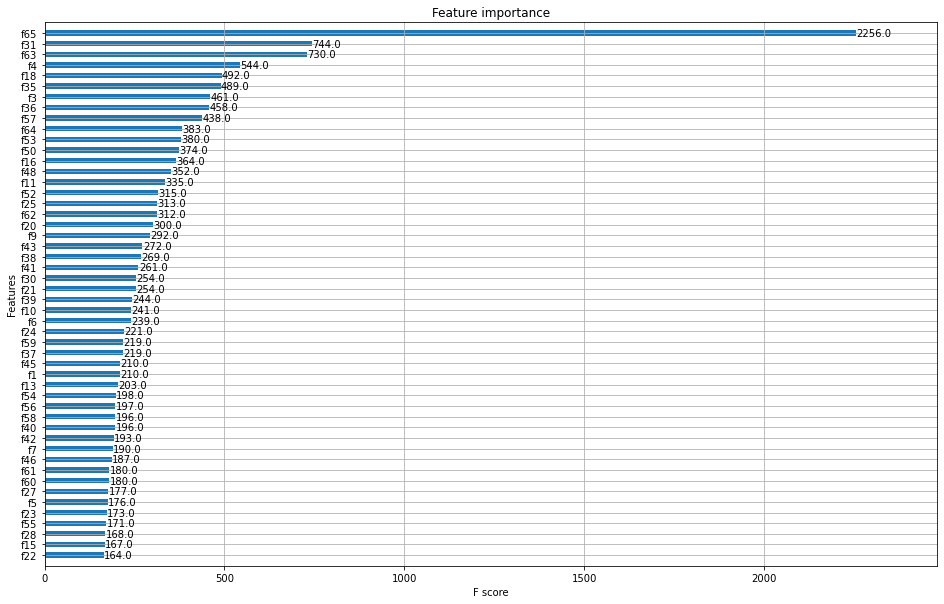

In [48]:
figsize(16, 10)
xgb.plot_importance(models[0], 
                    max_num_features=50, 
                    height=0.5, 
                    importance_type='weight')

Check feature importance

In [49]:
def check_feature_importance(models, features=features):
    scores_weight = [model.get_score(importance_type='weight')
                     for model in models]
    res = pd.DataFrame()
    res['feature'] = list(set(scores_weight[0].keys()))
    res['feature_name'] = res['feature'].apply(lambda x: x.replace('f', ''))\
                                        .apply(int)\
                                        .apply(lambda x: features[x])
    res['avg_weight'] = res['feature'].apply(lambda x: np.mean([w[x] 
                                                                for w in scores_weight]))
    res = res.sort_values('avg_weight', ascending=False)
    res['rank'] = list(range(1, len(res)+1))
    return res

In [50]:
df_feature_importance = check_feature_importance(models)

In [51]:
df_feature_importance.head(20)

,feature,feature_name,avg_weight,rank
31,f65,Diff538rating,2334.0,1
39,f63,B538rating,582.8,2
9,f31,A538rating,567.8,3
7,f3,A_Tm_off_TO%_RS,353.8,4
43,f4,A_Tm_off_OR%_RS,353.6,5
41,f50,B_Tm_off_TO%_L30,349.6,6
27,f35,B_Tm_off_TO%_RS,342.2,7
1,f36,B_Tm_off_OR%_RS,339.2,8
60,f64,DiffSeed,330.6,9
51,f18,A_Tm_off_TO%_L30,325.8,10


In [52]:
df_feature_importance.tail(20)

,feature,feature_name,avg_weight,rank
63,f33,B_Tm_off_PP100P_RS,114.4,47
20,f27,A_Tm_net_eFG_L30,113.6,48
57,f40,B_Tm_def_TO%_RS,113.4,49
56,f55,B_Tm_def_TO%_L30,113.0,50
10,f51,B_Tm_off_OR%_L30,112.8,51
64,f47,B_Tm_net_FTr_RS,110.8,52
61,f15,A_Tm_net_FTr_RS,108.0,53
6,f58,B_Tm_net_PP100P_L30,107.0,54
29,f8,A_Tm_def_TO%_RS,106.6,55
28,f12,A_Tm_net_eFG_RS,103.6,56


In [53]:
df_feature_importance[df_feature_importance['feature_name'].str.contains('PP100P')]

,feature,feature_name,avg_weight,rank
3,f11,A_Tm_net_PP100P_RS,258.0,11
34,f43,B_Tm_net_PP100P_RS,246.0,12
62,f38,B_Tm_def_PP100P_RS,242.8,13
30,f16,A_Tm_off_PP100P_L30,228.6,15
8,f6,A_Tm_def_PP100P_RS,215.4,17
23,f48,B_Tm_off_PP100P_L30,211.6,18
4,f53,B_Tm_def_PP100P_L30,194.0,21
53,f21,A_Tm_def_PP100P_L30,170.2,23
65,f1,A_Tm_off_PP100P_RS,122.4,42
63,f33,B_Tm_off_PP100P_RS,114.4,47


In [54]:
df_feature_importance[df_feature_importance['feature_name'].str.contains('Seed')]

,feature,feature_name,avg_weight,rank
60,f64,DiffSeed,330.6,9
14,f32,BSeed,94.6,60
5,f0,ASeed,92.8,61


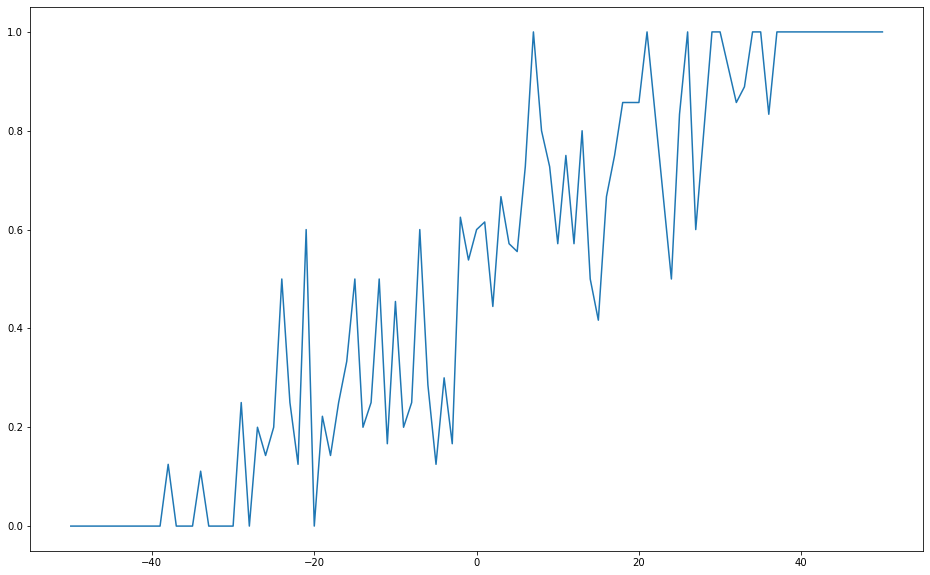

In [55]:
plot_df = pd.DataFrame({'pred': oof_preds[0], 'label': np.where(y > 0, 1, 0)})
plot_df['pred_int'] = plot_df['pred'].apply(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='avg_win_pct')

figsize(16, 10)
plt.plot(plot_df['pred_int'], plot_df['avg_win_pct'])

### Step 2: Predict winning probabilities based on the predicted gaps

In [56]:
eps = 0.00001

In [57]:
spline_model = []

for i in range(n_cv):
    print(f'Fold {i}')
    dat = list(zip(oof_preds[i], np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    print(f'Before Clip: Min={spline_fit.min():.3f}, Max={spline_fit.max():.3f}')
    score = log_loss(np.where(y > 0, 1, 0), spline_fit)
    print(f'logloss of cvsplit {i}: {score:.3f}') 
    spline_fit = np.clip(spline_fit, 0 + eps, 1 - eps)
    print(f'After Clip: Min={spline_fit.min()}, Max={spline_fit.max()}')
    score = log_loss(np.where(y > 0, 1, 0), spline_fit)
    print(f'logloss of cvsplit {i}: {score:.3f}') 
    print()
    

Fold 0
Before Clip: Min=-0.029, Max=1.010
logloss of cvsplit 0: 0.435
After Clip: Min=1e-05, Max=0.99999
logloss of cvsplit 0: 0.435

Fold 1
Before Clip: Min=-0.054, Max=1.050
logloss of cvsplit 1: 0.439
After Clip: Min=1e-05, Max=0.99999
logloss of cvsplit 1: 0.439

Fold 2
Before Clip: Min=-0.031, Max=1.033
logloss of cvsplit 2: 0.436
After Clip: Min=1e-05, Max=0.99999
logloss of cvsplit 2: 0.436

Fold 3
Before Clip: Min=-0.039, Max=1.042
logloss of cvsplit 3: 0.427
After Clip: Min=1e-05, Max=0.99999
logloss of cvsplit 3: 0.427

Fold 4
Before Clip: Min=-0.017, Max=1.013
logloss of cvsplit 4: 0.433
After Clip: Min=1e-05, Max=0.99999
logloss of cvsplit 4: 0.433



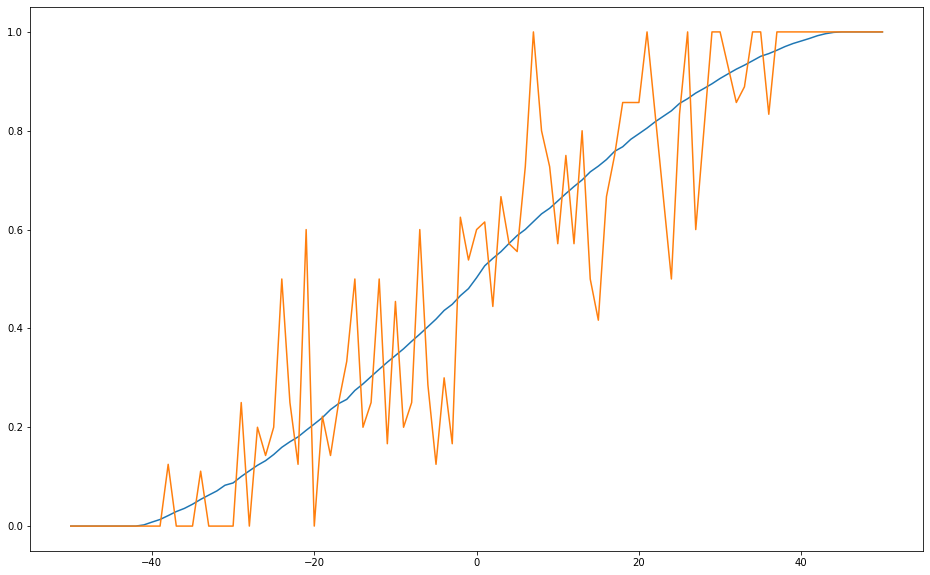

In [58]:
plot_df = pd.DataFrame({'pred': oof_preds[0], 
                        'label': np.where(y > 0, 1, 0), 
                        'spline': np.clip(spline_model[0](oof_preds[0]), 0, 1)})
plot_df['pred_int'] = plot_df['pred'].apply(int)
plot_df = plot_df.groupby('pred_int')['spline', 'label'].mean().reset_index()

figsize(16, 10)
plt.plot(plot_df['pred_int'], plot_df['spline'])
plt.plot(plot_df['pred_int'], plot_df['label'])

## Test

In [59]:
df_test = pd.read_csv(f'{directory.replace("2", "1")}/WSampleSubmissionStage1.csv')

In [60]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['ATeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['BTeamID'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [61]:
for s in ['A', 'B']:
    df_test = df_test.merge(add_side(df_features_season, s),
                            on=['Season', f'{s}TeamID'],
                            how='left')

In [62]:
df_test = compute_diff(df_test, diff_cols)

In [63]:
set(df.columns) - set(df_test.columns), set(df_test.columns) - set(df.columns)

({'APP100P', 'AScore', 'BPP100P', 'BScore', 'DiffPP100P', 'DiffScore', 'WinA'},
 {'ID', 'Pred'})

In [64]:
X_test = df_test[features].values
dtest = xgb.DMatrix(X_test)

In [65]:
test_models = []

for i in range(n_cv):
    print(f'Fold {i}')
    test_models.append(xgb.train(params=param,
                                 dtrain=dtrain,
                                 num_boost_round=int(iteration_counts[i] * 1.1),
                                 verbose_eval=50))
    print()

Fold 0
[18:19:40] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Fold 1
[18:19:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Fold 2
[18:19:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" }

In [66]:
test_preds = []
for i in range(n_cv):
    pp100p_diff_pred = np.clip(test_models[i].predict(dtest), -50, 50)
    test_preds.append(np.clip(spline_model[i](pp100p_diff_pred), 
                              0 + eps, 1 - eps))
    
df_test['Pred'] = pd.DataFrame(test_preds).mean(axis=0)

Manually edit the predictions of following scenarios based on the history (https://en.wikipedia.org/wiki/NCAA_Division_I_Women%27s_Basketball_Tournament_upsets):
- Seeds 1/2/3 pass the first round
- Seeds 1 pass the second round

In [67]:
df_test['Pred_Risky'] = df_test['Pred']
df_test.loc[(df_test['ASeed'] == 16) & (df_test['BSeed'] == 1), 
            'Pred_Risky'] = 0 + eps
df_test.loc[(df_test['ASeed'].isin([8, 9])) & (df_test['BSeed'] == 1), 
            'Pred_Risky'] = 0 + eps
df_test.loc[(df_test['ASeed'] == 15) & (df_test['BSeed'] == 2), 
            'Pred_Risky'] = 0 + eps
df_test.loc[(df_test['ASeed'] == 14) & (df_test['BSeed'] == 3), 
            'Pred_Risky'] = 0 + eps
df_test.loc[(df_test['ASeed'] == 1) & (df_test['BSeed'] == 16), 
            'Pred_Risky'] = 1 - eps
df_test.loc[(df_test['ASeed'] == 1) & (df_test['BSeed'].isin([8, 9])), 
            'Pred_Risky'] = 1 - eps
df_test.loc[(df_test['ASeed'] == 2) & (df_test['BSeed'] == 15), 
            'Pred_Risky'] = 1 - eps
df_test.loc[(df_test['ASeed'] == 3) & (df_test['BSeed'] == 14), 
            'Pred_Risky'] = 1 - eps

In [68]:
def show_test_res(df, df_test, pred_col):
    temp = df[['Season', 'ATeamID', 'ASeed', 'BTeamID', 'BSeed', 'WinA']]\
           .merge(df_test[[pred_col, 'Season', 'ATeamID', 'BTeamID']],
                  on=['Season', 'ATeamID', 'BTeamID'], 
                  how='inner')
    print(log_loss(temp['WinA'], temp[pred_col]))
    return temp.groupby('Season').apply(lambda x: log_loss(x['WinA'], x[pred_col]))

In [69]:
show_test_res(df, df_test, 'Pred')

0.3720483878210492


Season
2016    0.374238
2017    0.375372
2018    0.391171
2019    0.347112
2021    0.372349
dtype: float64

Results of training starting from 2016 (XGB)  
Season  
2016    0.374238  
2017    0.375372  
2018    0.391171  
2019    0.347112  
2021    0.372349  
dtype: float64  

Results of training starting from 2016 (XGB) Didn't use 2021 data  
Season  
2016    0.378817  
2017    0.379126  
2018    0.394850  
2019    0.353472  
2021    0.378208  
dtype: float64

In [70]:
show_test_res(df, df_test, 'Pred_Risky')

0.36325570170317495


Season
2016    0.369481
2017    0.369689
2018    0.384443
2019    0.335163
2021    0.357503
dtype: float64

Results of training starting from 2016 (XGB)  
Season  
2016    0.369481  
2017    0.369689  
2018    0.384443  
2019    0.335163  
2021    0.357503  
dtype: float64

Results of training starting from 2016 (XGB) Didn't use 2021 data  
Season  
2016    0.372414  
2017    0.372150  
2018    0.386498  
2019    0.339898  
2021    0.361153  
dtype: float64  

## Submission

In [71]:
df_sub = pd.read_csv(f'{directory}/WSampleSubmissionStage2.csv')

In [72]:
df_sub['Season'] = df_sub['ID'].apply(lambda x: int(x.split('_')[0]))
df_sub['ATeamID'] = df_sub['ID'].apply(lambda x: int(x.split('_')[1]))
df_sub['BTeamID'] = df_sub['ID'].apply(lambda x: int(x.split('_')[2]))

In [73]:
for s in ['A', 'B']:
    df_sub = df_sub.merge(add_side(df_features_season, s),
                          on=['Season', f'{s}TeamID'],
                          how='left')

In [74]:
df_sub = compute_diff(df_sub, diff_cols)

In [75]:
set(df.columns) - set(df_sub.columns), set(df_sub.columns) - set(df.columns)

({'APP100P', 'AScore', 'BPP100P', 'BScore', 'DiffPP100P', 'DiffScore', 'WinA'},
 {'ID', 'Pred'})

In [76]:
X_sub = df_sub[features].values
dsub = xgb.DMatrix(X_sub)

In [77]:
sub_models = []

for i in range(n_cv):
    print(f'Fold {i}')
    sub_models.append(xgb.train(params=param,
                                dtrain=dtrain,
                                num_boost_round=int(iteration_counts[i] * 1.1),
                                verbose_eval=50))
    print()

Fold 0
[18:25:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Fold 1
[18:25:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Fold 2
[18:25:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" }

In [78]:
sub_preds = []
for i in range(n_cv):
    pp100p_diff_pred = np.clip(sub_models[i].predict(dsub), -50, 50)
    sub_preds.append(np.clip(spline_model[i](pp100p_diff_pred), 
                             0 + eps, 1 - eps))
    
df_sub['Pred'] = pd.DataFrame(sub_preds).mean(axis=0)
df_sub['Pred'].min(), df_sub['Pred'].max() 

(1e-05, 0.99999)

In [79]:
df_sub['Pred_Risky'] = df_sub['Pred']
df_sub.loc[(df_sub['ASeed'] == 16) & (df_sub['BSeed'] == 1), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'].isin([8, 9])) & (df_sub['BSeed'] == 1), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'] == 15) & (df_sub['BSeed'] == 2), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'] == 14) & (df_sub['BSeed'] == 3), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'] == 1) & (df_sub['BSeed'] == 16), 
            'Pred_Risky'] = 1 - eps
df_sub.loc[(df_sub['ASeed'] == 1) & (df_sub['BSeed'].isin([8, 9])), 
            'Pred_Risky'] = 1 - eps
df_sub.loc[(df_sub['ASeed'] == 2) & (df_sub['BSeed'] == 15), 
            'Pred_Risky'] = 1 - eps
df_sub.loc[(df_sub['ASeed'] == 3) & (df_sub['BSeed'] == 14), 
            'Pred_Risky'] = 1 - eps

In [80]:
df_sub[['ID', 'Pred']].head()

,ID,Pred
0,2022_3107_3110,0.483309
1,2022_3107_3112,0.011496
2,2022_3107_3116,0.080946
3,2022_3107_3124,0.000845
4,2022_3107_3125,0.248177


### Save

In [ ]:
# df_sub[['ID', 'Pred']].to_csv('ncaaw_safe.csv', index=False)

In [ ]:
# df_sub[['ID', 'Pred_Risky']].rename(columns={'Pred_Risky': 'Pred'})\
# .to_csv('ncaaw_risky.csv', index=False)

For tournament recap purpose

In [ ]:
# temp = df_sub[['ID', 'Pred_Risky', 'ATeamID', 'BTeamID']].rename(columns={'Pred_Risky': 'Pred'})
# team_dict = {row[0]: row[1] for row in df_538[['TeamID', 'TeamName']].drop_duplicates().values}
# temp['ATeam'] = temp['ATeamID'].map(team_dict)
# temp['BTeam'] = temp['BTeamID'].map(team_dict)
# temp[['ID', 'Pred', 'ATeam', 'ATeamID', 'BTeam', 'BTeamID']].to_csv('ncaaw_risky_full.csv', index=False)

## Submission (The UConn/Paige Bueckers Adjustment)

Since Paige Bueckers was out for the majority of the season, so adjust UConn's 538 rating to the level of Stanford/NC State for recap purpose

In [94]:
df_features_season[(df_features_season['Season'] == 2022) & 
                   (df_features_season['Seed'] == 1)][['Season', 'Seed', 'TeamID', '538rating']]

,Season,Seed,TeamID,538rating
320,2022,1,3301,101.77
337,2022,1,3390,101.82
354,2022,1,3376,106.35
372,2022,1,3257,97.66


In [95]:
df_features_season[(df_features_season['Season'] == 2022) & 
                   (df_features_season['TeamID'] == 3163)][['Season', 'Seed', 'TeamID', '538rating']]

,Season,Seed,TeamID,538rating
321,2022,2,3163,98.34


In [101]:
df_features_season_adj = df_features_season.copy()
df_features_season_adj.loc[(df_features_season_adj['Season'] == 2022) & 
                           (df_features_season_adj['TeamID'] == 3163), '538rating'] = (101.77 + 101.82) / 2
df_features_season_adj[(df_features_season_adj['Season'] == 2022) & 
                       (df_features_season_adj['TeamID'] == 3163)][['Season', 'Seed', 'TeamID', '538rating']]

,Season,Seed,TeamID,538rating
321,2022,2,3163,101.795


In [102]:
df_sub = pd.read_csv(f'{directory}/WSampleSubmissionStage2.csv')

In [103]:
df_sub['Season'] = df_sub['ID'].apply(lambda x: int(x.split('_')[0]))
df_sub['ATeamID'] = df_sub['ID'].apply(lambda x: int(x.split('_')[1]))
df_sub['BTeamID'] = df_sub['ID'].apply(lambda x: int(x.split('_')[2]))

In [104]:
for s in ['A', 'B']:
    df_sub = df_sub.merge(add_side(df_features_season_adj, s),
                          on=['Season', f'{s}TeamID'],
                          how='left')

In [105]:
df_sub = compute_diff(df_sub, diff_cols)

In [106]:
X_sub = df_sub[features].values
dsub = xgb.DMatrix(X_sub)

In [107]:
sub_models = []

for i in range(n_cv):
    print(f'Fold {i}')
    sub_models.append(xgb.train(params=param,
                                dtrain=dtrain,
                                num_boost_round=int(iteration_counts[i] * 1.1),
                                verbose_eval=50))
    print()

Fold 0
[18:37:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Fold 1
[18:37:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



Fold 2
[18:37:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" }

In [108]:
sub_preds = []
for i in range(n_cv):
    pp100p_diff_pred = np.clip(sub_models[i].predict(dsub), -50, 50)
    sub_preds.append(np.clip(spline_model[i](pp100p_diff_pred), 
                             0 + eps, 1 - eps))
    
df_sub['Pred'] = pd.DataFrame(sub_preds).mean(axis=0)
df_sub['Pred'].min(), df_sub['Pred'].max() 

(1e-05, 0.99999)

In [109]:
df_sub['Pred_Risky'] = df_sub['Pred']
df_sub.loc[(df_sub['ASeed'] == 16) & (df_sub['BSeed'] == 1), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'].isin([8, 9])) & (df_sub['BSeed'] == 1), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'] == 15) & (df_sub['BSeed'] == 2), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'] == 14) & (df_sub['BSeed'] == 3), 
            'Pred_Risky'] = 0 + eps
df_sub.loc[(df_sub['ASeed'] == 1) & (df_sub['BSeed'] == 16), 
            'Pred_Risky'] = 1 - eps
df_sub.loc[(df_sub['ASeed'] == 1) & (df_sub['BSeed'].isin([8, 9])), 
            'Pred_Risky'] = 1 - eps
df_sub.loc[(df_sub['ASeed'] == 2) & (df_sub['BSeed'] == 15), 
            'Pred_Risky'] = 1 - eps
df_sub.loc[(df_sub['ASeed'] == 3) & (df_sub['BSeed'] == 14), 
            'Pred_Risky'] = 1 - eps

In [ ]:
# temp = df_sub[['ID', 'Pred_Risky', 'ATeamID', 'BTeamID']].rename(columns={'Pred_Risky': 'Pred'})
# team_dict = {row[0]: row[1] for row in df_538[['TeamID', 'TeamName']].drop_duplicates().values}
# temp['ATeam'] = temp['ATeamID'].map(team_dict)
# temp['BTeam'] = temp['BTeamID'].map(team_dict)
# temp[['ID', 'Pred', 'ATeam', 'ATeamID', 'BTeam', 'BTeamID']].to_csv('ncaaw_risky_full_uconn.csv', index=False)